In [ ]:
import pandas as pd

df = pd.read_csv('/content/inmates.csv')

df.head()

,inmate_id,last_name,first_name_middle_initial,admitted_date,photo_filename,gender,height,weight,hair_color,eye_color,ethnic_origin,custody_class,admission,release_date,release_type,complex,unit,last_movement,status
0,359372,SMITH,"ADAM, B.",01/24/2023,359372.jpg,Male,6 f 0,255.0,Brown,Green,Caucasian,Medium/Low,01/24/23,06/13/2025,CSBD,YUMA,YUMA CIBOLA,02/12/2025,Active
1,241159,SMITH,"ADAM, L.",11/04/2015,241159.jpg,Male,5 f 7,290.0,Brown,Green,Caucasian,Medium/Moderate,11/04/15,12/15/2031,CSBD,TUCSON,TUCSON RINCON,01/13/2025,Active
2,341611,SMITH,"ADAM, L.",06/05/2024,341611.jpg,Male,5 f 7,170.0,Brown,Blue,Caucasian,Medium/Low,06/05/24,01/29/2026,ERCD,CACF,CACF-FLORENCE,06/11/2024,Active
3,306519,SMITH,"ADAM, W.",12/10/2015,306519.jpg,Male,5 f 7,165.0,Brown,Blue,Caucasian,Medium/Moderate,12/10/15,01/10/2033,SENTENCE EXPIRATION,EYMAN,EYMAN COOK,03/17/2025,Active
4,367762,SMITH,ADRIAN,04/08/2024,367762.jpg,Male,5 f 10,180.0,Blonde,Blue,Caucasian,Minimum/Moderate,04/08/24,09/18/2026,TR to ADD,TUCSON,TUCSON WHETSTONE,12/04/2024,Active


In [ ]:
# Count female
female_inmates_count = df[df['gender'].str.lower() == 'female'].shape[0]

# Count Male
male_inmates_count = df[df['gender'].str.lower() == 'male'].shape[0]

print("Number of female inmates:", female_inmates_count)
print("Number of male inmates:", male_inmates_count)

Number of female inmates: 483
Number of male inmates: 3664


In [ ]:
df['gender'] = df['gender'].str.lower()

# Separate
df_female = df[df['gender'] == 'female']
df_male = df[df['gender'] == 'male']

num_females = df_female.shape[0]

male_sample = df_male.sample(n=num_females, random_state=42)

balanced_df = pd.concat([df_female, male_sample])

male_dropped = df_male.drop(male_sample.index)

dropped_df = male_dropped.copy()

Number of female inmates: 483


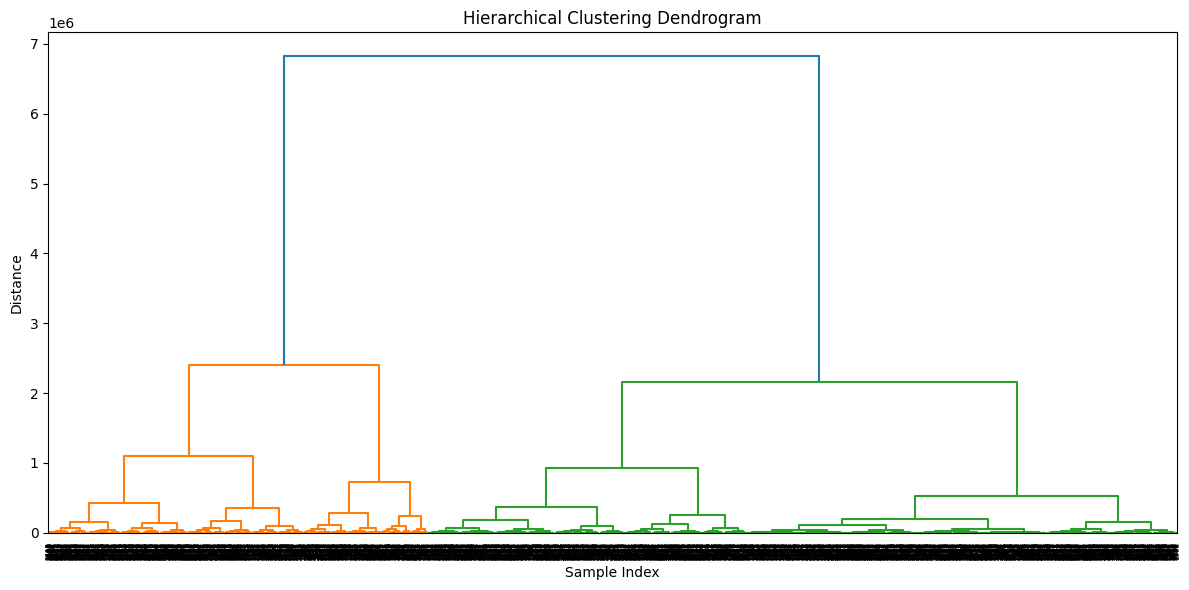

Balanced DataFrame shape: (966, 19)
Dropped male records shape: (3181, 19)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Preprocessing
df['gender'] = df['gender'].str.lower()
df_female = df[df['gender'] == 'female']
df_male = df[df['gender'] == 'male']
num_females = df_female.shape[0]
print("Number of female inmates:", num_females)

# Numeric columns + impute
X_male_raw = df_male.select_dtypes(include=[np.number])
imputer = SimpleImputer(strategy='mean')
X_male_imputed = imputer.fit_transform(X_male_raw)
X_male = pd.DataFrame(X_male_imputed, columns=X_male_raw.columns, index=X_male_raw.index)

# Agglomerative clustering
agglo = AgglomerativeClustering(n_clusters=num_females, linkage='ward')
clusters = agglo.fit_predict(X_male)

# Dendrogram
linked = linkage(X_male, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# Select representative inmate from each cluster
selected_indices = []
for cluster_label in np.unique(clusters):
    cluster_indices = np.where(clusters == cluster_label)[0]
    cluster_samples = X_male.iloc[cluster_indices]
    cluster_center = cluster_samples.mean().values
    distances = cdist(cluster_samples, [cluster_center], metric='euclidean').flatten()
    min_idx_in_cluster = cluster_indices[np.argmin(distances)]
    selected_indices.append(min_idx_in_cluster)

# Build datasets
male_selected = df_male.iloc[selected_indices]
all_male_indices = set(range(df_male.shape[0]))
dropped_indices = list(all_male_indices - set(selected_indices))
male_dropped = df_male.iloc[dropped_indices]
balanced_inmates_df = pd.concat([df_female, male_selected])

# Summary
print("Balanced DataFrame shape:", balanced_inmates_df.shape)
print("Dropped male records shape:", male_dropped.shape)

In [ ]:
 male_dropped['inmate_id']

,inmate_id
0,359372
1,241159
2,341611
3,306519
4,367762
...,...
3659,253372
3660,128383
3661,294739
3662,285429


In [ ]:
# Classifications.csv Data filtering

classifications_df = pd.read_csv('/content/classifications.csv')

filtered_classification  = classifications_df[classifications_df['inmate_id'].isin(male_dropped['inmate_id'])]

new_classification_df = classifications_df.drop(filtered_classification.index)

new_classification_df

,inmate_id,complete_date,classification_type,custody_risk,internal_risk
21,197527,Active Classification,Reclassification,Close,High
22,197527,12/11/2024,Reclassification,Maximum,Highest
23,197527,03/06/2024,Reclassification,Close,High
24,197527,12/18/2023,Reclassification,Close,High
25,197527,08/24/2023,Reclassification,Close,High
...,...,...,...,...,...
48486,314941,Active Classification,Initial Classification,Minimum,Low
48487,314941,12/22/2023,Reclassification,Minimum,Low
48488,314941,11/15/2022,Initial Classification,Medium,Low
48489,314941,04/04/2022,Reclassification,Minimum,Low


In [ ]:
# Detainers.csv Data filtering

detainers_df = pd.read_csv('/content/detainers.csv')

filtered_detainers  = detainers_df[detainers_df['inmate_id'].isin(male_dropped['inmate_id'])]

new_detainers_df = detainers_df.drop(filtered_detainers.index)

new_detainers_df

,inmate_id,detainer_date,detainer_type,charges,authority,agreement_date
7,197527,09/19/2024,Notification Request,CR2024-006634-004,Clerk of the Court,NaN
8,197527,03/13/2024,Notification Request,CR2020-001102-001,Clerk of the Court,NaN
9,197527,11/05/2018,Notification Request,CR2011008105,Clerk of the Court,NaN
10,255984,07/24/2018,Notification Request,CR 2015-147024,Clerk of the Court,NaN
11,255984,07/09/2018,Notification Request,CR2015147024001 LIFE,In State Probation,NaN
...,...,...,...,...,...,...
6849,345864,05/23/2024,Notification Request,CR2023-007749-001,Clerk of the Court,NaN
6850,345864,05/23/2024,Notification Request,CR2023-008060-001,Clerk of the Court,NaN
6851,328184,03/16/2023,Notification Request,2022120948,In State Probation,NaN
6852,328184,01/24/2023,Notification Request,2022-129407,Clerk of the Court,NaN


In [ ]:
# Infractions.csv Data filtering

infractions_df = pd.read_csv('/content/infractions.csv')

filtered_infractions  = infractions_df[infractions_df['inmate_id'].isin(male_dropped['inmate_id'])]

new_infractions_df = infractions_df.drop(filtered_infractions.index)

new_infractions_df

,inmate_id,violation_date,infraction,verdict_date,verdict
13,197527,02/27/2024,Possession of Communication Device,03/06/2024,Major - Guilty
14,197527,02/18/2024,Harassment,02/28/2024,Major - Guilty
15,197527,10/21/2023,Disorderly Conduct,11/03/2023,Major - Uphold
16,197527,08/02/2023,Possession of Communication Device,08/09/2023,Major - Guilty
17,197527,01/13/2023,Resisting or Disobeying a Verbal or Written Order,02/09/2023,Major - Guilty
...,...,...,...,...,...
18581,328184,11/21/2023,Positive Test or Refusal of UA,12/04/2023,Major - Uphold
18582,328184,10/25/2023,Fighting,11/20/2023,Major - Guilty
18583,328184,05/13/2023,Violation of any Published Department or Insti...,05/26/2023,Major - Guilty
18584,328184,02/20/2023,Attempt to Commit a Class A Offense,03/02/2023,Major - Uphold


In [ ]:
# Parole_Actions.csv Data filtering

parole_actions_df = pd.read_csv('/content/parole_actions.csv')

filtered_parole_actions  = parole_actions_df[parole_actions_df['inmate_id'].isin(male_dropped['inmate_id'])]

new_parole_actions_df = parole_actions_df.drop(filtered_parole_actions.index)

new_parole_actions_df

,inmate_id,hearing_date,statute,action
0,71970,06/05/1991,"31-412 Regular Parole,",DENY
1,71970,06/05/1991,"41-1604.13 Home Arrest,",DENY
2,71970,10/03/1991,"31-412 Regular Parole,",DENY
3,71970,10/03/1991,"41-1604.13 Home Arrest,",DENY
4,71970,02/05/1992,"31-412 Regular Parole,",DENY
...,...,...,...,...
1939,82283,12/16/1997,"31-412 Regular Parole,",DENY
1940,82283,12/16/1997,"41-1604.13 Home Arrest,",GRANT
1941,118045,05/16/2019,"31-411 Absolute Discharge,",DENY
1942,118045,05/16/2019,"31-412 Regular Parole,",DENY


In [ ]:
# Sentences.csv Data filtering

sentences_df = pd.read_csv('/content/sentences.csv')

filtered_sentences  = sentences_df[sentences_df['inmate_id'].isin(male_dropped['inmate_id'])]

new_sentences_df = sentences_df.drop(filtered_sentences.index)

new_sentences_df

,inmate_id,commit_num,sentence_length,county,cause_num,offense_date,sentence_date,sentence_status,crime
15,197527,A01,004 Y/00 M/00D,Maricopa County,2005108258002D,03/18/2005,08/01/2005,Imposed,ARMED ROBBERY
16,197527,B01,003 Y/00 M/00D,Pinal County,200701980,01/15/2007,10/03/2008,Imposed,AGGRAVATED ASSAULT
17,197527,C02,014 Y/00 M/ 00 D,Maricopa County,2011-105867-001,02/02/2011,11/29/2011,Imposed,AGGRAVATED ASSAULT
18,197527,D01,005 Y/00 M/ 00 D,Maricopa County,2011-008105-001,10/29/2011,06/25/2012,Imposed,AGGRAVATED ASSAULT
19,197527,D02,003 Y/00 M/ 00 D,Maricopa County,2011-008105-001,10/29/2011,06/25/2012,Imposed,PRSNR ASSLT W/BODY FLUIDS
...,...,...,...,...,...,...,...,...,...
18243,314941,C01,002 Y/00 M/ 00 D,Maricopa County,2015-000190-001,02/14/2014,12/14/2023,Imposed,ATTEMPTED DANGEROUS DRUG VIOLATION
18244,314941,D01,002 Y/00 M/ 00 D,Maricopa County,2015-127013-001,06/11/2015,12/14/2023,Imposed,DANGEROUS DRUG VIOLATION
18245,314941,E03,002 Y/00 M/ 00 D,Maricopa County,2023-138184-001,08/24/2023,12/14/2023,Imposed,NARCOTIC DRUG VIOLATION
18246,314941,F02,002 Y/00 M/ 00 D,Maricopa County,2020-000487-001,07/06/2020,12/14/2023,Imposed,NARCOTIC DRUG VIOLATION


In [ ]:
# Work_Programs.csv Data filtering
work_programs_df = pd.read_csv('/content/work_programs.csv')

filtered_work_programs = work_programs_df[work_programs_df['inmate_id'].isin(male_dropped['inmate_id'])]

new_work_programs_df = work_programs_df.drop(filtered_work_programs.index)

new_work_programs_df

,inmate_id,assigned_date,completed_date,work_assignment
13,197527,03/28/2025,NaN,Changing Offender Behavior (Credentialed Staff...
14,197527,12/19/2024,01/29/2025,C2chg-Peers
15,197527,03/25/2023,05/19/2023,C2chg-Self Control
16,197527,02/25/2021,03/02/2021,HAZELDEN EDUCATION
17,197527,10/01/2019,10/31/2019,C2chg-Responsible Thinking
...,...,...,...,...
21683,330707,12/17/2018,07/16/2019,Cog/Think For A Change
21684,184842,12/28/2023,03/12/2024,Changing Offender Behavior (Credentialed Staff...
21685,184842,08/17/2015,01/04/2016,Reentry Program (Merging Two Worlds)
21686,314941,04/18/2024,06/11/2024,C2chg-Family Ties


In [ ]:
# Appeals.csv Data filtering
appeals_df = pd.read_csv('/content/appeals.csv')

filtered_appeals = appeals_df[appeals_df['inmate_id'].isin(male_dropped['inmate_id'])]

new_appeals_df = appeals_df.drop(filtered_appeals.index)

new_appeals_df

,inmate_id,appeal_date,outcome,as_of_date
1,197527,05/11/2021,Uphold,06/14/2021
2,197527,08/12/2020,Uphold,08/21/2020
3,197527,06/28/2017,Uphold,06/28/2017
4,197527,05/17/2017,Uphold,05/17/2017
5,197527,01/22/2016,Uphold,01/22/2016
...,...,...,...,...
2017,266314,12/19/2023,Uphold,01/03/2024
2018,266314,02/29/2016,Uphold,02/29/2016
2019,266314,12/13/2011,Uphold,12/13/2011
2020,328184,06/07/2024,Uphold,07/01/2024


In [ ]:
balanced_inmates_df.to_csv("inmates.csv", index=False)

In [ ]:
new_classification_df.to_csv("classifications.csv", index=False)

In [ ]:
new_detainers_df.to_csv("detainers.csv", index=False)

In [ ]:
new_infractions_df.to_csv("infractions.csv", index=False)

In [ ]:
new_parole_actions_df.to_csv("parole_actions.csv", index=False)

In [ ]:
new_sentences_df.to_csv("sentences.csv", index=False)

In [ ]:
new_work_programs_df.to_csv("work_programs.csv", index=False)

In [ ]:
new_appeals_df.to_csv("appeals.csv", index=False)

In [ ]:
# Save the dropped inmate IDs to a text file (one per line)
male_dropped["inmate_id"].to_csv("dropped_ids.txt", index=False, header=False)